In [1]:
# Import modules

%matplotlib notebook
import tensorflow as tf
from tensorflow import keras
from graph_model import CallBacks, DataGenerator, GraphNet

import numpy as np
from scipy.interpolate import Rbf
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy, shapely
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.geodesic import Geodesic

import pandas as pd
import os
import pickle
import shutil
import random
import json

In [2]:
tf.config.set_visible_devices([], 'GPU')

In [3]:
# Define the data directories
model_name = "max-aggregate2_dropout=0.15+Gaussian"

cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
save_dir = os.path.join(cwd, "save", model_name)
save_exp_dir = os.path.join(cwd, "save/exps")
processed_waveform_dir = os.path.join(data_dir, "waveforms_proc_broadband")

savefile_best = "best-model.h5"
savefile_last = "last-model.h5"

In [4]:
if not os.path.isdir(save_exp_dir):
    os.mkdir(save_exp_dir)

# Data preparation
# Modify Data ranges accordingly

In [5]:
# Fix random seed for reproducibility
# Note: keep this seed the same as during data preparation and training!
np.random.seed(0)

# Data ranges (min/max)
minlatitude = 32
maxlatitude = 36
minlongitude = -120
maxlongitude = -116
maxdepth = 30e3
minmag = 3
maxmag = 6

# Fraction of the data to be used in training
split = 0.8

In [6]:
def scale(x):
    """ Function to scale the data in the range +/- 1 """
    if len(x.shape) == 2:
        x[:, 0] = (x[:, 0] - minlatitude) / (maxlatitude - minlatitude)
        x[:, 1] = (x[:, 1] - minlongitude) / (maxlongitude - minlongitude)
        x[:, 2] = x[:, 2] / maxdepth
        x[:, 3] = (x[:, 3] - minmag) / (maxmag - minmag)
    elif len(x.shape) == 3:
        x[:, :, 0] = (x[:, :, 0] - minlatitude) / (maxlatitude - minlatitude)
        x[:, :, 1] = (x[:, :, 1] - minlongitude) / (maxlongitude - minlongitude)
        x[:, :, 2] = x[:, :, 2] / maxdepth
        x[:, :, 3] = (x[:, :, 3] - minmag) / (maxmag - minmag)
    x = (x - 0.5) * 2
    return x


def unscale(x):
    """ Function to unscale the data """
    x = x / 2 + 0.5
    if len(x.shape) == 2:
        x[:, 0] = x[:, 0] * (maxlatitude - minlatitude) + minlatitude
        x[:, 1] = x[:, 1] * (maxlongitude - minlongitude) + minlongitude
        x[:, 2] = x[:, 2] * maxdepth * 1e-3
        x[:, 3] = x[:, 3] * (maxmag - minmag) + minmag
    elif len(x.shape) == 3:
        x[:, :, 0] = x[:, :, 0] * (maxlatitude - minlatitude) + minlatitude
        x[:, :, 1] = x[:, :, 1] * (maxlongitude - minlongitude) + minlongitude
        x[:, :, 2] = x[:, :, 2] * maxdepth * 1e-3
        x[:, :, 3] = x[:, :, 3] * (maxmag - minmag) + minmag
    return x

# ====== Please modify station network below ======

In [7]:
# Create station look-up table
stations_look_up = pd.read_csv(os.path.join(data_dir, "stations.csv"))[["code", "lat", "lon"]]
# please change network name accordingly
stations_look_up["network"] = "CI"  # e.g. stations["network"] = "CI"  
stations_look_up = stations_look_up.rename(columns={"code":"station_name","lat":"station_lat","lon":"station_lon"})
stations_look_up.to_csv(f'{save_exp_dir}/station_lookups.csv')

# ====== Please modify above ======

<IPython.core.display.Javascript object>


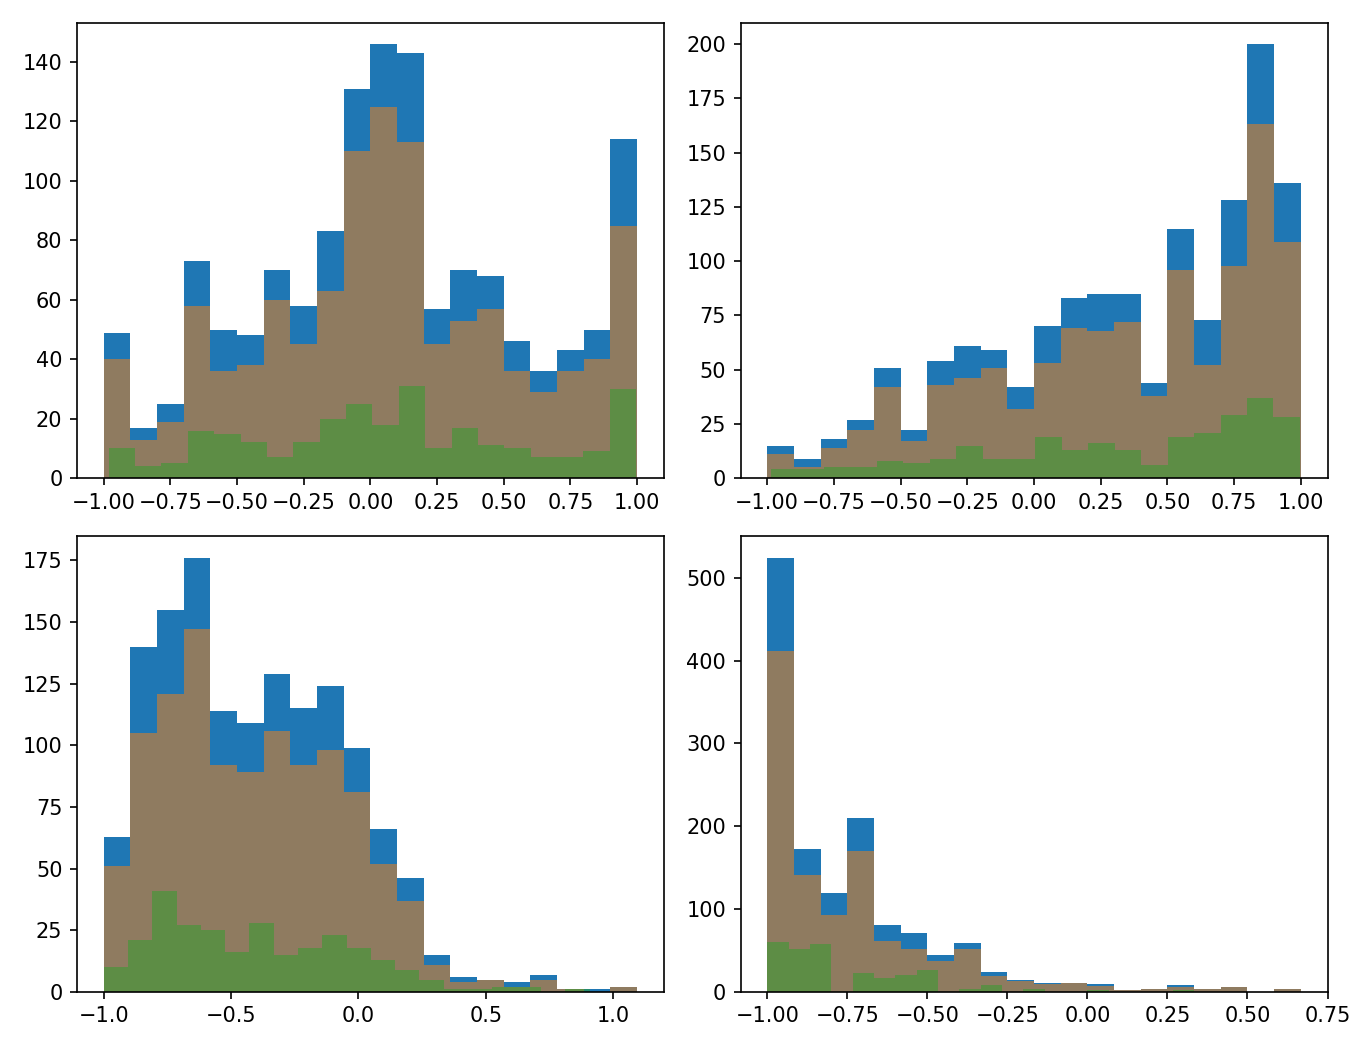

In [8]:
# Get the event catalogue
catalogue = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))[["lat", "lon", "depth", "mag"]]

# Check which events have data
for i, event in catalogue.iterrows():
    # Event data file
    cat_file = os.path.join(processed_waveform_dir, "%d.npy" % i)
    # If file not exists: remove event from catalogue
    if not os.path.isfile(cat_file):
        catalogue.drop(index=i, inplace=True)

# Event identifiers
ids = catalogue.index.values
# Uniform weights
weights = np.ones((len(ids), 1))
# Event lat/lon/depth/magnitude
catalogue = catalogue.values

# Scale the catalogue data
catalogue = scale(catalogue)
# Concatenate the IDs and weights to the catalogue data
catalogue = np.concatenate([ids.reshape(-1, 1), weights.reshape(-1, 1), catalogue], axis=1)

# Split events into train and validation sets
inds = np.arange(catalogue.shape[0])
np.random.shuffle(inds)
N_split = int(split * catalogue.shape[0])

train_inds = inds[:N_split]
test_inds = inds[N_split:]

# Split catalogue
train_catalogue = catalogue[train_inds]
test_catalogue = catalogue[test_inds]

# Check data distributions to ensure that train and validation sets are similar!
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
axes = axes.ravel()

for i in range(4):
    ax = axes[i]
    ax.hist(catalogue[:, i+2], bins=20, density=False)
    ax.hist(train_catalogue[:, i+2], bins=20, alpha=0.5, density=False)
    ax.hist(test_catalogue[:, i+2], bins=20, alpha=0.5, density=False)

plt.tight_layout()    
plt.show()

# Rescale station locs

In [9]:
# Read seismic station information
stations = pd.read_csv(os.path.join(data_dir, "stations.csv"))[["code", "lat", "lon"]]
# Scale station geographic locations
stations["lat"] = ((stations["lat"] - minlatitude) / (maxlatitude - minlatitude) - 0.5) * 2
stations["lon"] = ((stations["lon"] - minlongitude) / (maxlongitude - minlongitude) - 0.5) * 2

# Load model

In [10]:
# Reload the best model state
last_file = os.path.join(save_dir, savefile_best)
model = keras.models.load_model(last_file)

In [11]:
# Open the event-station lookup file
lookup_file = os.path.join(data_dir, "catalogue_station_lookup_final.pickle")

with open(lookup_file, "rb") as f:
    lookup = pickle.load(f)

# Initiate data for training

In [12]:
# Number of stations per sample
N_sub = 50
# Number of time sample points
N_t = 2048

# Instantiate data generator
eval_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
)

# New functions for creating json/csv outputs

In [13]:
def make_ground_truth_lookup(eval_generator, area, data_dir):
    # this function take in the lookup in eval_generator and output a pandas dataframe
    evids = eval_generator.event_inds
    # identify area code
    if area == 'California':
        area_code = 1
    elif area == 'Pacific':
        area_code = 3
    elif area == 'Oklahoma':
        area_code = 5
    else:
        area_code = 7
    # read in original catalog
    catalogue = pd.read_csv(os.path.join(data_dir, "catalogue.csv"))
    data = []
    
    for i in range(len(evids)):
        GTevtID = f'GT{area_code}{evids[i]:04d}'
        try:
            all_stations = eval_generator.lookup[evids[i]].tolist()
        except:
            all_stations = []
        data.append({  'eathquake_id' : GTevtID,
                        'stations': all_stations,
                        'evt_lat': catalogue.iloc[evids[i]]["lat"],
                        'evt_lon': catalogue.iloc[evids[i]]["lon"],
                        'evt_dep': catalogue.iloc[evids[i]]["depth"]/1000,
                        'evt_mag': catalogue.iloc[evids[i]]["mag"],
                        'event_time': catalogue.iloc[evids[i]]["time"],
        })
    return data

In [15]:
def make_look_up_sub(eval_generator, min_perc=0.3, max_perc=0.9):
    
    # Will modify lookup, station_coords, and waveforms
    new_eval_generator = eval_generator
    event_ids = new_eval_generator.event_inds
    station_lookups = eval_generator.selected_stations.copy()
    
    # loop over the lookups
    for i in range(len(event_ids)):
        size_look_up = len(station_lookups[i])       # num of stations selected
        rand_perc = random.uniform(min_perc, max_perc) # randomly pick percentage of statiosn to keep
        num_sta_to_pick = round(size_look_up * rand_perc) # number of stations to keep
        index_to_keep = np.random.choice(range(size_look_up),num_sta_to_pick,replace=False) # index of randomly picked stations
        
        # updated lookups
        look_up_update = station_lookups[i][index_to_keep]
        new_eval_generator.selected_stations[i] = look_up_update.copy()

        # updated waveform
        zeros_temp = np.zeros(eval_generator.waveforms[i].shape)
        zeros_temp[0:len(index_to_keep)] = eval_generator.waveforms[i][index_to_keep]
        new_eval_generator.waveforms[i] = zeros_temp.copy()
        
        # update station coords
        zeros_coords = np.zeros(eval_generator.station_coords[i].shape)
        zeros_coords[0:len(index_to_keep)] = eval_generator.station_coords[i][index_to_keep]
        new_eval_generator.station_coords[i] = zeros_coords.copy()
     #  except:
     #  print(f'no event for index {i}, skip')
    return new_eval_generator

In [16]:
def append_to_opt_json(opt_json, area, strt_index, new_eval_generator,
                       scaled_results, scaled_results_std, 
                       err_dist, err_lat, err_lon, err_depth, err_mag
                      ):
    # ---- identify area code
    if area == 'California':
        area_code = 1
    elif area == 'Pacific':
        area_code = 3
    elif area == 'oklahoma':
        area_code = 5
    else:
        area_code = 7
    # ---- mean of errs
    mean_err_dist = err_dist.mean(axis=0)
    mean_err_lat = err_lat.mean(axis=0)
    mean_err_lon = err_lon.mean(axis=0)
    mean_err_depth = err_depth.mean(axis=0)
    mean_err_mag = err_mag.mean(axis=0)
    # ---- loop over each of the events
    for i in range(new_eval_generator.N_events):
        # Get GT evtID
        evids = new_eval_generator.event_inds[i]
        GTevtID = f'GT{area_code}{evids:04d}'
        #print(GTevtID)
        opt_json.append({'earthquake_id':GTevtID,
                        'exp_id': f'PT{strt_index:03d}',
                        'stations': new_eval_generator.selected_stations[i].tolist(),
                        'evt_lat': scaled_results[i][0],
                        'evt_lon': scaled_results[i][1],
                        'evt_dep': scaled_results[i][2],
                        'evt_mag': scaled_results[i][3],
                        'evt_dist_err': mean_err_dist[i],
                        'evt_lat_err': mean_err_lat[i],
                        'evt_lon_err': mean_err_lon[i],
                        'evt_dep_err': mean_err_depth[i],
                        'evt_mag_err': mean_err_mag[i],
                        'evt_lat_std': scaled_results_std[i][0],
                        'evt_lon_std': scaled_results_std[i][1],
                        'evt_dep_std': scaled_results_std[i][2],
                        'evt_mag_std': scaled_results_std[i][3],
                        })
    return opt_json

# ====== Please modify 1st cell below ======

In [17]:
# Please change area code to either "California", "Pacific", or "Oklahoma"
area_code = "California"
# Please set number of experienments
num_of_experienment = 10 
# Number of evaluations per sample
N_eval = 20
# Range of Incompletness
min_perc = 0.6
max_perc = 0.9

In [18]:
# Create Ground truth look up table
GT_evt_lookup = make_ground_truth_lookup(eval_generator, area_code, data_dir)
with open(f'{save_exp_dir}/ground_truth_lookup.txt', 'w') as outfile:
    json.dump(GT_evt_lookup, outfile)

# ====== Please modify 1st cell above ======

In [19]:
# save train/test ids
np.save(f"{save_exp_dir}/train_inds.npy",train_inds)
np.save(f"{save_exp_dir}/test_inds.npy",test_inds)

# initialize the output json file
# opt_json = initiate_output_json(eval_generator, area_code)
opt_json = []

# running exps
for iteration in range(num_of_experienment):
    
    print(f'=== running exp # {iteration}')
    
    # Instantiate data generator
    eval_generator = DataGenerator(
    data_dir=processed_waveform_dir,
    catalogue=catalogue,
    stations=stations,
    lookup=lookup,
    N_sub=N_sub,
    N_t=N_t,
    batch_size=32,
    )
    
    # make incomplete subset
    new_eval_generator = make_look_up_sub(eval_generator, min_perc, max_perc)
    
    # Extract quantities from the data generator
    waveforms = new_eval_generator.waveforms
    coords = new_eval_generator.station_coords
    weights = new_eval_generator.weights
    labels = new_eval_generator.labels

    # Buffer for the posterior samples
    all_results = np.zeros((N_eval, len(labels), 4))

    # Perform inference N_eval times
    for i in range(N_eval):
        print(f'{i} th evaluation for exp # {iteration}')
        # Store predictions in buffer
        all_results[i] = model.predict((waveforms, coords, weights))

    # Get the mean and standard deviation of the model posterior
    results = np.mean(all_results, axis=0)
    results_std = np.std(all_results, axis=0)

    # Scale the results back to physical units
    scaled_results = unscale(results)
    scaled_all_results = unscale(all_results)
    scaled_results_std = np.std(scaled_all_results, axis=0)
    scaled_labels = unscale(labels)
    tiled_labels = np.tile(scaled_labels, [N_eval, 1, 1])
    
    # Conversion factor from degrees to kilometres
    latlon_km = 40075 / 360.

    # Compute the errors in the predictions
    err_dist = np.sqrt((scaled_all_results[:, :, 0] - tiled_labels[:, :, 0])**2 + (scaled_all_results[:, :, 1] - tiled_labels[:, :, 1])**2) * latlon_km
    err_lat = np.abs(scaled_all_results[:, :, 0] - tiled_labels[:, :, 0])
    err_lon = np.abs(scaled_all_results[:, :, 1] - tiled_labels[:, :, 1])
    err_depth = np.abs(scaled_all_results[:, :, 2] - tiled_labels[:, :, 2])
    err_mag = np.abs(scaled_all_results[:, :, 3] - tiled_labels[:, :, 3])
    err_all = np.abs(scaled_all_results - tiled_labels)

    # Report prediction errors and precision
    print("Location error: %.2f +/- %.2f km" % (err_dist.mean(), err_dist.std()))
    print("Depth error: %.2f +/- %.2f km" % (err_depth.mean(), err_depth.std()))
    print("Magnitude error: %.2f +/- %.2f" % (err_mag.mean(), err_mag.std()))
    
    # Save posterior to a NumPy file
    outfile = f"{save_exp_dir}/results_ref_{iteration}.npy"
    np.save(outfile, scaled_all_results)
    
    # Save scaled labels to a Numpy file
    outfile_labell = f"{save_exp_dir}/scaled_label_{iteration}.npy"
    np.save(outfile_labell, scaled_labels)
    
    # Save errors to a Numpy file
    err_all_file = f"{save_exp_dir}/err_all_{iteration}.npy"
    np.save(err_all_file, err_all)
    
    # save to output json file 
    print(f'adding results of exp # {iteration} to json file')
    opt_json = append_to_opt_json(opt_json, area_code, iteration, new_eval_generator,
                       scaled_results, scaled_results_std, 
                       err_dist, err_lat, err_lon, err_depth, err_mag
                      )

# save to output
print(f'writing output to json file')
with open(f'{save_exp_dir}/experienment.txt', 'w') as outfile:
    json.dump(opt_json, outfile)

=== running exp # 0
0 th evaluation for exp # 0
1 th evaluation for exp # 0
2 th evaluation for exp # 0
3 th evaluation for exp # 0
4 th evaluation for exp # 0
5 th evaluation for exp # 0
6 th evaluation for exp # 0
7 th evaluation for exp # 0
8 th evaluation for exp # 0
9 th evaluation for exp # 0
10 th evaluation for exp # 0
11 th evaluation for exp # 0
12 th evaluation for exp # 0
13 th evaluation for exp # 0
14 th evaluation for exp # 0
15 th evaluation for exp # 0
16 th evaluation for exp # 0
17 th evaluation for exp # 0
18 th evaluation for exp # 0
19 th evaluation for exp # 0
Location error: 26.32 +/- 25.61 km
Depth error: 3.39 +/- 2.90 km
Magnitude error: 0.15 +/- 0.17
adding results of exp # 0 to json file
=== running exp # 1
0 th evaluation for exp # 1
1 th evaluation for exp # 1
2 th evaluation for exp # 1
3 th evaluation for exp # 1
4 th evaluation for exp # 1
5 th evaluation for exp # 1
6 th evaluation for exp # 1
7 th evaluation for exp # 1
8 th evaluation for exp # 1
9 t

# Reference results

Since the model enables dropout at inference time, the model predictions for the seismic source characteristics are probabilistic. By evaluating a single input sample multiple times, we get an approximate posterior distribution from which we can estimate model uncertainties and confidence intervals.

Compute prediction accuracy and precision from the model posterior. Then, save the results to a NumPy file:

In [22]:
# Plot results for a particular iteration
iteration = 3
intfile = f"{save_exp_dir}/results_ref_{iteration}.npy"
intfile_label = f"{save_exp_dir}/scaled_label_{iteration}.npy"
err_all_file = f"{save_exp_dir}/err_all_{iteration}.npy"
train_inds = np.load(f"{save_exp_dir}/train_inds.npy")
test_inds = np.load(f"{save_exp_dir}/test_inds.npy")

<IPython.core.display.Javascript object>


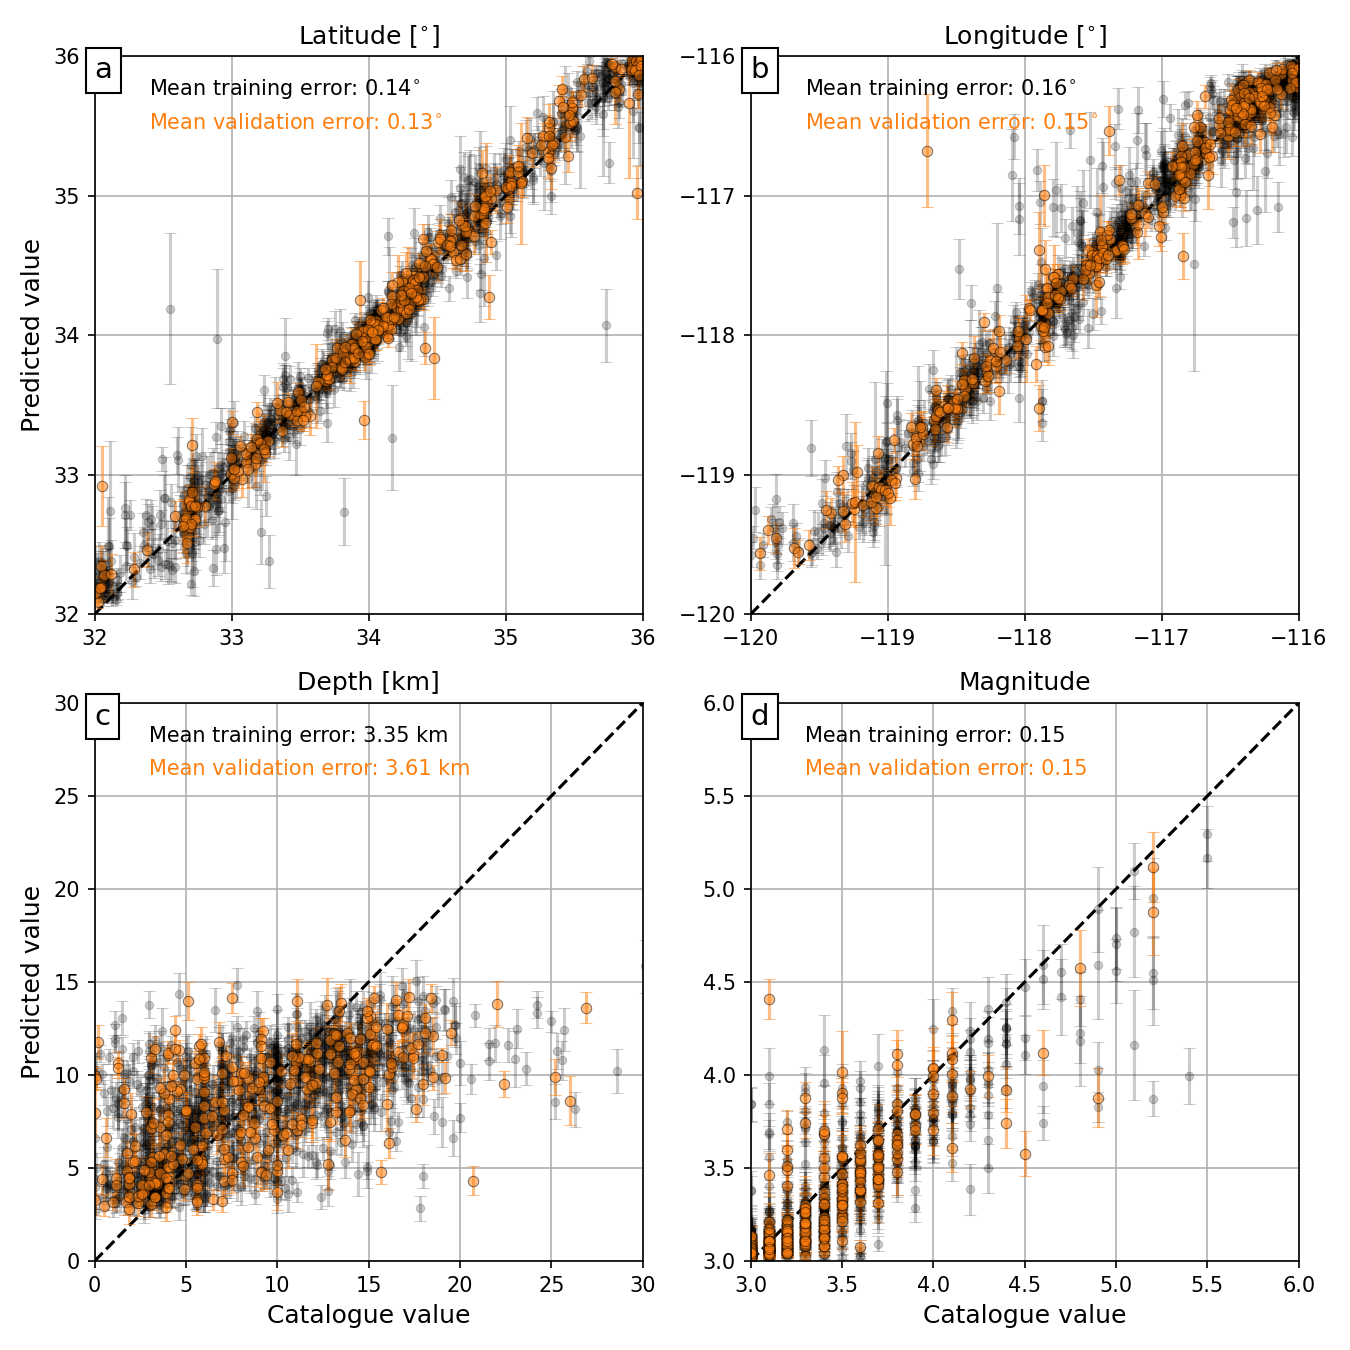

In [23]:
""" Plot results: Supplementary Figure S1 """


# Reload the posterior of the reference model
results_ref = np.load(intfile)
scaled_labels = np.load(intfile_label)
err_all = np.load(err_all_file)

# Get the mean and standard deviation of the model posterior
scaled_results = np.mean(results_ref, axis=0)
results_std = np.std(results_ref, axis=0)

# Prepare a 2x2 figure canvas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
axes = axes.ravel()

# Define titles, panel letters, etc.
titles = (r"Latitude [$^{\circ}$]", r"Longitude [$^{\circ}$]", "Depth [km]", "Magnitude")
ticks = (
    np.linspace(minlatitude, maxlatitude, 5),
    np.linspace(minlongitude, maxlongitude, 5),
    np.linspace(0, maxdepth * 1e-3, 7),
    np.linspace(minmag, maxmag, 7),
)
ranges = ((minlatitude, maxlatitude), (minlongitude, maxlongitude), (0, maxdepth * 1e-3), (minmag, maxmag))
units = (r"$^{\circ}$", r"$^{\circ}$", " km", "")
letters = "abcd"

# Loop over lat/lon/depth/magnitude quantities
for i in range(4):
    ax = axes[i]
    # Set title
    ax.set_title(titles[i])
    # Write panel letter
    ax.text(
        x=0.0, y=1, transform=ax.transAxes, s=letters[i], fontsize=14, 
        verticalalignment="top", bbox={"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
    )
    # Plot 1:1 line
    ax.plot(ranges[i], ranges[i], "k--")
    # Plot data
    ax.errorbar(
        scaled_labels[train_inds, i], scaled_results[train_inds, i], yerr=results_std[train_inds, i], 
        fmt="o", ms=4, alpha=0.2, mfc="k", ecolor="k", mec="k", mew=0.5, capsize=3,
    )
    ax.errorbar(
        scaled_labels[test_inds, i], scaled_results[test_inds, i], yerr=results_std[test_inds, i], 
        fmt="o", ms=5, alpha=0.5, mfc="C1", ecolor="C1", mec="k", mew=0.5, capsize=3,
    )
    # Add error estimates
    ax.text(
        x=0.1, y=0.93, transform=ax.transAxes, c="k",
        s=r"Mean training error: %.2f%s" % (err_all[:, train_inds, i].mean(), units[i])
    )
    ax.text(
        x=0.1, y=0.87, transform=ax.transAxes, c="C1",
        s=r"Mean validation error: %.2f%s" % (err_all[:, test_inds, i].mean(), units[i])
    )
    
    # Format axes
    if i // 2 == 1:
        ax.set_xlabel("Catalogue value", fontsize=12)
    if i % 2 == 0:
        ax.set_ylabel("Predicted value", fontsize=12)
    ax.set_xlim(ranges[i])
    ax.set_ylim(ranges[i])
    ax.set_xticks(ticks[i])
    ax.set_yticks(ticks[i])
    ax.grid(b=True)

plt.tight_layout()
plt.savefig(f"figures/fig_S1_iter_{iteration}.pdf")
plt.show()